# Active Learning with Gaussian Processes


Let's start by getting some intuition for Multivariate Gaussians. In the following, we will draw 5 random samples for a two-dimensional Gaussian.

<ipython-input-1-b7da8dde0ea9>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  mycmap = plt.cm.get_cmap('winter',nsamples)


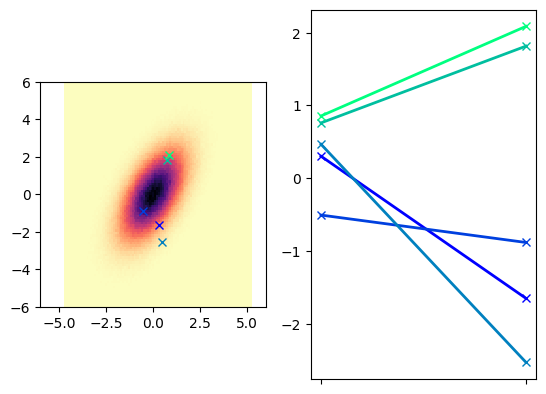

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
rng = np.random.default_rng() # sets up a random number generator
ndim= 2
nsamples = 5

# define the distribution and draw samples
mean=np.zeros(ndim) # zero mean
cov =np.array([[1,0.8],[0.8,2]]) # some covariance matrix with correlation present
samples = rng.multivariate_normal(mean,cov,nsamples)

# for reference, we will generate a ton of samples to visualize the "true" distribution
x1t,x2t = rng.multivariate_normal(mean,cov,1000000).T
fig,ax = plt.subplots(1,2)
ax[0].hist2d(x1t,x2t,bins=(100,100),cmap=plt.cm.magma_r)

# and we will overlay our samples on top of this
mycmap = plt.cm.get_cmap('winter',nsamples)
myColors = [mycmap(i/(nsamples-1.)) for i in range(nsamples)]
for i,sample in enumerate(samples):
  ax[0].plot(sample[0],sample[1],linestyle = 'none', marker = 'x', color = myColors[i],linewidth=5 )
ax[0].axis('square')
ax[0].set_xlim([-6,6])
ax[0].set_ylim([-6,6])

# Now we will also represent these same draws by plotting them
# as lines connecting the two Gaussian vectors
xrvs = [dim/(ndim-1.) for dim in range(ndim)]
for i,sample in enumerate(samples):
    ax[1].plot(xrvs,sample,linestyle='-',marker = 'x',color=myColors[i],linewidth=2)
ax[1].xaxis.set_ticks(xrvs)
ax[1].xaxis.set_ticklabels([])
plt.show()

Now, we will follow this up for a more complex situation of 30-dimensional Gaussian, of course we will not show the underlying distribution but only show the samples. We will choose to represent the covariance as
$$k(x_i,x_j) = \exp \left[-\frac{(x_i-x_j)^2}{2} \right]$$

<ipython-input-13-5695e4794435>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  mycmap = plt.cm.get_cmap('gist_rainbow',nsamples)


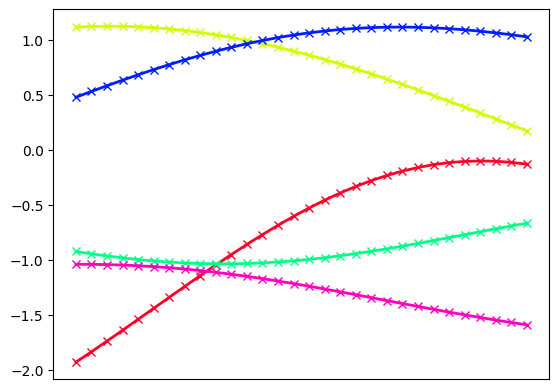

In [13]:
from scipy.spatial.distance import cdist
def covkernel(xi,xj,l=1.0):
    dij= cdist(xi,xj,metric='euclidean') # returns matrix of pairwise distances
    return np.exp(-0.5*dij**2/l**2)

ndim     = 30
nsamples = 5
xrvs     = np.linspace(0,1,ndim)[:,np.newaxis]
mycmap = plt.cm.get_cmap('gist_rainbow',nsamples)
myColors = [mycmap(i/(nsamples-1.)) for i in range(nsamples)]

# define the distribution and draw samples
mean=np.zeros(ndim) # zero mean
#Xij = covkernel(xrvs,xrvs)
cov = covkernel(xrvs,xrvs) # some covariance matrix with correlation present
samples = rng.multivariate_normal(mean,cov,nsamples)

# Represent the draws by plotting them
# as lines connecting the Gaussian vectors
fig,axs = plt.subplots(1)
for i,sample in enumerate(samples):
    axs.plot(xrvs,sample,linestyle='-',marker = 'x',color=myColors[i],linewidth=2)
axs.xaxis.set_ticks(list(xrvs[0]))
axs.axes.get_xaxis().set_visible(False)
#axs.set_xticklabels(['' for i in range(ndim)])
#axs.xaxis.set_ticklabels(['' for i in range(ndim)])

plt.show()


Now, let's see if we can generate a few "observations," and then sample the posterior. Let's assume our true function is something we know, like the Van der Waals equation of state:

$$P_r = \frac{8}{3}\frac{T_r}{V_r - \frac{1}{3}}-\frac{3}{V_r^2}$$

To keep this problem in a physically reasonable range, we will suppose $T_r = 0.85$ and examine $V_r$ over the range of 0.5 to 4. In the following, we can include fewer or more observations to illustrate how our uncertainty changes.

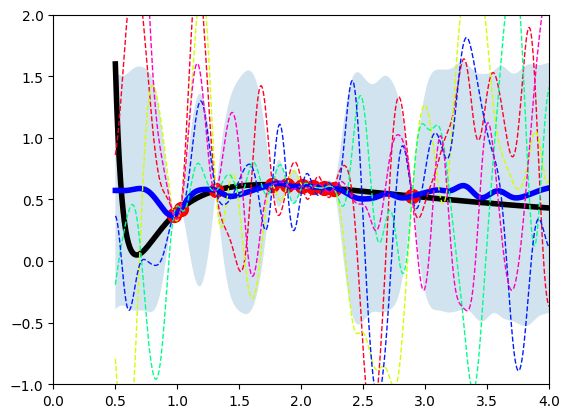

In [3]:
def vdw_P(Tr,Vr):
    term1 = 8.*Tr/(3*Vr-1)
    term2 = 3.0/(Vr*Vr)
    return term1 - term2

def make_plot(Vs,Ps,x,y):
    fig,axs = plt.subplots(1)
    axs.plot(Vs,Ps,linestyle='-',color='k',linewidth=4)
    axs.plot(x[:,0],y[:,0],linestyle='none',marker = 'o',color='r',markersize=10)
    axs.set_xlim([0,4])
    axs.set_ylim([-1,2])
    return fig,axs

def make_plot_posterior(axs,fmean,fp,fm):
    axs.fill_between(xs[:,0],fm,fp,alpha = 0.2)
    axs.plot(xs,fmean,linestyle='-',color='b',linewidth=4)
    return

# look at a reasonable range of parameters
Tr = 0.85
Vmin,Vmax = 0.5,4
Vs = np.linspace(Vmin,Vmax,1000)
Ps = vdw_P(Tr,Vs)

# generate random observations (over slightly smaller interval)
nobs = 10
x    = Vmin + (Vmax-1-Vmin)*rng.random(nobs) # random samples for V
x    = x[:,np.newaxis]
y    = vdw_P(Tr,x)
yavg = np.mean(y)
fig,axs = make_plot(Vs,Ps,x,y)

# now generate our test points (denoted *)
xs = Vs[:,np.newaxis]

# we need to get all of the relevant covariant matrices
length  = 0.1
kxsx    = covkernel(xs,x,l=length)
kxx     = covkernel(x,x,l=length)
invkxx  = np.linalg.inv(kxx)
kxsxs   = covkernel(xs,xs,l=length)
kxxs    = covkernel(x,xs,l=length)

# now we can sample the posterior with the following
# mean and covariance functions. We will generate a number of samples
# and then show a few for representation sake
# Note: as a "prior" to formulate the mean over our functions, we will use an ideal gas
# the observe mean
muf   = yavg
meanf = muf+kxsx@invkxx@(y-yavg) # <-- differs from earlier, when we assumed mean = 0
covf  = kxsxs - kxsx@invkxx@kxxs
nsamples = 500
samples  = rng.multivariate_normal(meanf[:,0],covf,nsamples)
sample_mean = np.mean(samples,axis=0)
sample_std  = np.std(samples,axis=0)
mean_plus   = sample_mean + 1*sample_std
mean_minus  = sample_mean - 1*sample_std
make_plot_posterior(axs,sample_mean,mean_minus,mean_plus)

for i,sample in enumerate(samples[:5]):
    axs.plot(xs,sample,linestyle='--',color=myColors[i],linewidth=1)

plt.show()

The above presumes noise-free observations and also uses a naive formulation scheme with direct sampling to obtain our results. The posterior mean and variance can actually be obtained directly as we will show next.

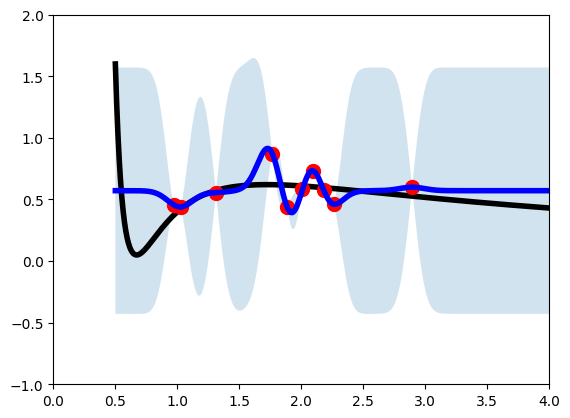

In [4]:
# new targets with noise:
sigma_n = 0.1

# add noise to previous observationsgenerate random observations
y    = vdw_P(Tr,x) + rng.normal(loc=0,scale=sigma_n,size=nobs)[:,np.newaxis]
yavg = np.mean(y)

# conventional algorithm
length  = 0.1
kxsx    = covkernel(xs,x,l=length)
kxx     = covkernel(x,x,l=length)
kxsxs   = covkernel(xs,xs,l=length)
kxxs    = covkernel(x,xs,l=length)

#meanf = muf+kxsx@invkxx@(y-yavg)
# 1. Cholesky decomposition of K(x,x)
L = np.linalg.cholesky(kxx)

# 2. Obtain alpha = L.T|(L|y) = L.T/b
b     = np.linalg.lstsq(L,y[:,0]-yavg,rcond=None)[0]
alpha = np.linalg.lstsq(L.T,b,rcond=None)[0]

# 3. Obtain the posterior mean function
fmean = yavg + kxxs.T@alpha

# 4. obtain posterior variance function
v = np.linalg.lstsq(L,kxxs,rcond=None)[0]
fvar = np.diag(kxsxs - v.T@v)
fstd = np.sqrt(fvar)
mean_plus   = fmean + 1*fstd
mean_minus  = fmean - 1*fstd

#plotting
fig,axs = make_plot(Vs,Ps,x,y)
make_plot_posterior(axs,fmean,mean_minus,mean_plus)
plt.show()

Now, we will simply repeat the exercise but using built-in functions from scikit-learn to do the GPR.

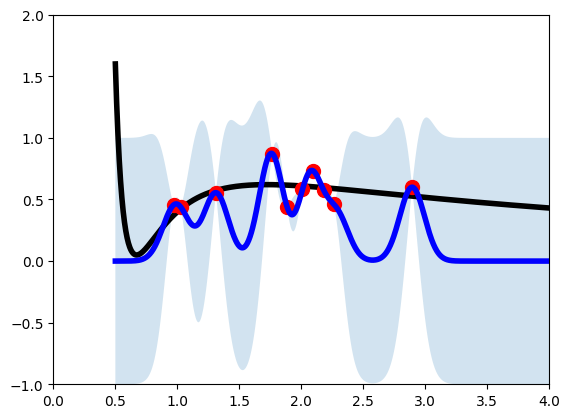

In [14]:
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process   import GaussianProcessRegressor
the_kernel = RBF(length_scale=0.1,length_scale_bounds="fixed")
the_model  = GaussianProcessRegressor(kernel=the_kernel)
the_model.fit(x,y)
fmean,fstd = the_model.predict(xs,return_std=True)
mean_plus   = fmean + 1*fstd
mean_minus  = fmean - 1*fstd
#mean_plus   = fmean[:,0] + 1*fstd
#mean_minus  = fmean[:,0] - 1*fstd

# plotting
fig,axs = make_plot(Vs,Ps,x,y)
make_plot_posterior(axs,fmean,mean_minus,mean_plus)
plt.show()

Notice that using scikit-learn it presumes that the mean should be zero! This highlights a need that we should probably normalized our data. Let's retry using a little bit of preprocessing...

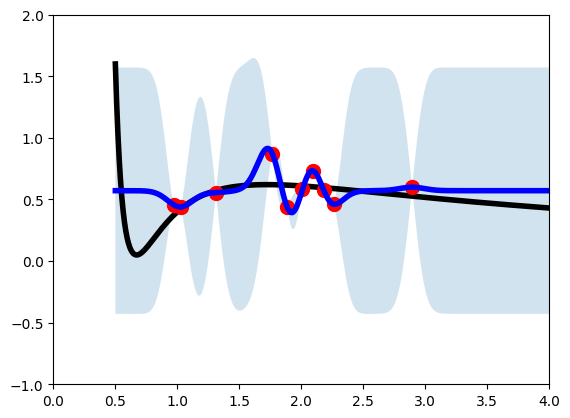

In [16]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(y)
yscaled= scaler.transform(y)
# to keep the comparison similar to before, we will
# also account for scaling to unit standard deviation
# newer versions of scikit-learn can use the option with_std = False
# but mine does not have this, and I do not want to update it right now

# fit to transformed y data, then inverse_transform
the_kernel = RBF(length_scale=0.1,length_scale_bounds="fixed")
the_model  = GaussianProcessRegressor(kernel=the_kernel)
the_model.fit(x,yscaled)
fmeanscaled,fstdscaled = the_model.predict(xs,return_std=True)
fmean       = scaler.inverse_transform(fmeanscaled.reshape(-1,1)).flatten()
mean_plus  = scaler.inverse_transform(fmeanscaled.reshape(-1,1)+ (1/scaler.scale_)*fstdscaled.reshape(-1,1)).flatten()
mean_minus = scaler.inverse_transform(fmeanscaled.reshape(-1,1)- (1/scaler.scale_)*fstdscaled.reshape(-1,1)).flatten()
#mean_plus   = scaler.inverse_transform(fmeanscaled[:,0].reshape(-1,1)+ (1/scaler.scale_)*fstdscaled.reshape(-1,1)).flatten()
#mean_minus  = scaler.inverse_transform(fmeanscaled[:,0].reshape(-1,1)- (1/scaler.scale_)*fstdscaled.reshape(-1,1)).flatten()

#plotting
fig,axs = make_plot(Vs,Ps,x,y)

make_plot_posterior(axs,fmean,mean_minus,mean_plus)
plt.show()

Building towards Active Learning.

Optima: x=0.900, y=0.810


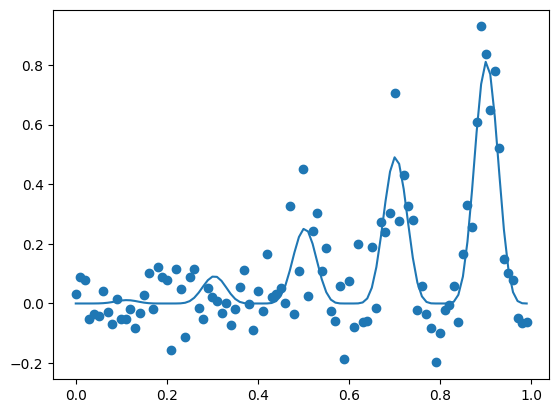

In [17]:
# objective function
def objective(x, noise=0.1):
	noise = np.random.normal(loc=0, scale=noise)
	return (x**2 * np.sin(5 * np.pi * x)**6.0) + noise

# grid-based sample of the domain [0,1]
X = np.arange(0, 1, 0.01)
# sample the domain without noise
y = [objective(x, 0) for x in X]
# sample the domain with noise
ynoise = [objective(x) for x in X]
# find best result
ix = np.argmax(y)
print('Optima: x=%.3f, y=%.3f' % (X[ix], y[ix]))
# plot the points with noise
plt.scatter(X, ynoise)
# plot the points without noise
plt.plot(X, y)
# show the plot
plt.show()

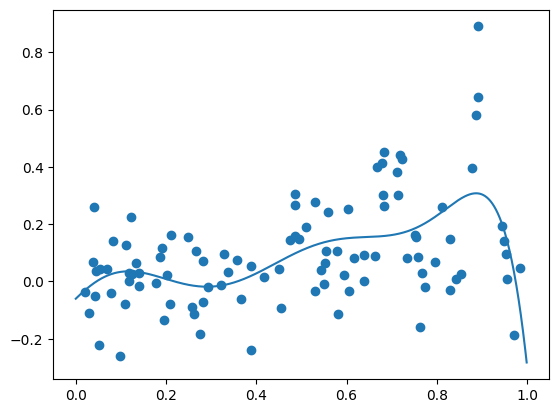

In [18]:
def surrogate(model, X):
	# catch any warning generated when making a prediction
	return model.predict(X, return_std=True)

# plot real observations vs surrogate function
def plot(X, y, model):
	# scatter plot of inputs and real objective function
	plt.scatter(X, y)
	# line plot of surrogate function across domain
	Xsamples = np.asarray(np.arange(0, 1, 0.001))
	Xsamples = Xsamples.reshape(len(Xsamples), 1)
	ysamples, _ = surrogate(model, Xsamples)
	plt.plot(Xsamples, ysamples)
	# show the plot
	plt.show()

# sample the domain sparsely with noise
X = np.random.random(100)
y = np.asarray([objective(x) for x in X])
# reshape into rows and cols
X = X.reshape(len(X), 1)
y = y.reshape(len(y), 1)
# define the model
model = GaussianProcessRegressor()
# fit the model
model.fit(X, y)
# plot the surrogate function
plot(X, y, model)

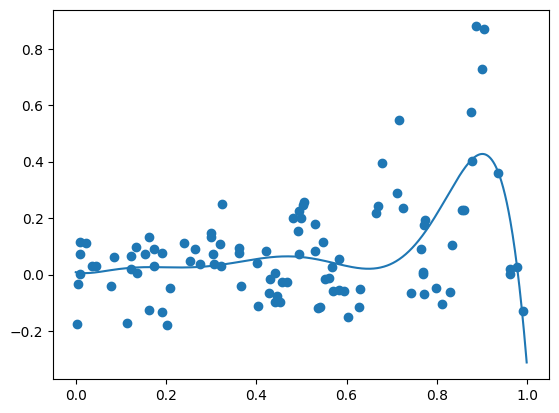

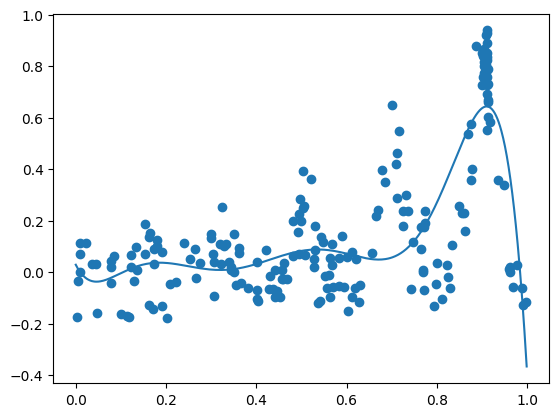

Best Result: x=0.910, y=0.939


<ipython-input-22-d08d42e6c1b9>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Best Result: x=%.3f, y=%.3f' % (X[ix], y[ix]))


In [22]:
# probability of improvement acquisition function
def acquisition(X, Xsamples, model):
	# calculate the best surrogate score found so far
	yhat, _ = surrogate(model, X)
	best = np.max(yhat)
	# calculate mean and stdev via surrogate function
	mu, std = surrogate(model, Xsamples)
	#mu = mu[0]
	# calculate the probability of improvement
	probs = norm.cdf((mu - best) / (std+1E-9))
	return probs

# optimize the acquisition function
def opt_acquisition(X, y, model):
	# random search, generate random samples
	Xsamples = np.random.random(100)
	Xsamples = Xsamples.reshape(len(Xsamples), 1)
	# calculate the acquisition function for each sample
	scores = acquisition(X, Xsamples, model)
	# locate the index of the largest scores
	ix = np.argmax(scores)
	return Xsamples[ix, 0]


# sample the domain sparsely with noise
X = np.random.random(100)
y = np.asarray([objective(x) for x in X])
# reshape into rows and cols
X = X.reshape(len(X), 1)
y = y.reshape(len(y), 1)
# define the model
model = GaussianProcessRegressor()
# fit the model
model.fit(X, y)
# plot before hand
plot(X, y, model)
# perform the optimization process
for i in range(100):
	# select the next point to sample
	x = opt_acquisition(X, y, model)
	# sample the point
	actual = objective(x)
	# summarize the finding
	est, _ = surrogate(model, [[x]])
	#print('>x=%.3f, f()=%3f, actual=%.3f' % (x, est, actual))
	# add the data to the dataset
	X = np.vstack((X, [[x]]))
	y = np.vstack((y, [[actual]]))
	# update the model
	model.fit(X, y)

# plot all samples and the final surrogate function
plot(X, y, model)
# best result
ix = np.argmax(y)
print('Best Result: x=%.3f, y=%.3f' % (X[ix], y[ix]))

Now, let's simply explore the space. Pick the next point to sample using the predicted uncertainty.

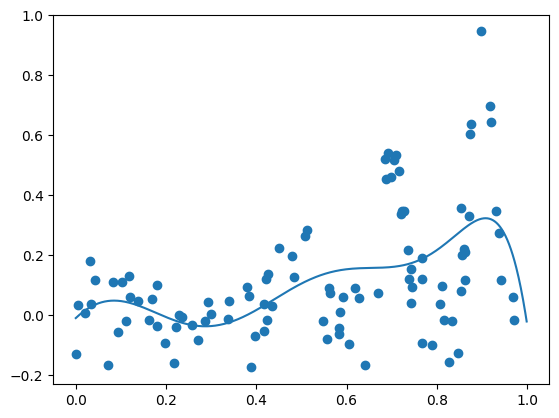

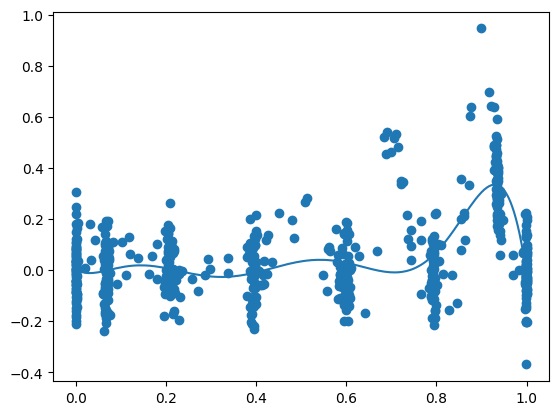

In [25]:
### BEGIN SOLUTION

# sample the domain sparsely with noise
X = np.random.random(100)
y = np.asarray([objective(x) for x in X])
# reshape into rows and cols
X = X.reshape(len(X), 1)
y = y.reshape(len(y), 1)
# define the model
model = GaussianProcessRegressor()
# fit the model
model.fit(X, y)
# plot before hand
plot(X, y, model)
# perform the optimization process
for i in range(500):
	# select the next point to sample
  Xsamples = np.random.random(100)
  Xsamples = Xsamples.reshape(len(Xsamples),1)
  mu, std = model.predict(Xsamples, return_std=True)
	# sample the point
  x = Xsamples[np.argmax(std)]
  actual = objective(x)
	# summarize the finding
	# add the data to the dataset
  X = np.vstack((X, [x]))
  y = np.vstack((y, [actual]))
	# update the model
  model.fit(X, y)

# plot all samples and the final surrogate function
plot(X, y, model)

### END SOLUTION